In [1]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
import os

import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

Using TensorFlow backend.


In [2]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

# 讀取資料並檢視
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## 首先我們使用一般的 DNN (MLP) 來訓練
由於 DNN 只能輸入一維的資料，我們要先將影像進行攤平，若 (50000, 32, 32, 3) 的影像，攤平後會變成 (50000, 32*32*3) = (50000, 3072)

In [3]:
# 將資料攤平成一維資料
x_train = x_train.reshape(50000, 3072) 
x_test = x_test.reshape(10000, 3072)

# 將資料變為 float32 並標準化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [4]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(3072,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 1,841,162
Trainable params: 1,841,162
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s

## 接下來我們使用 CNN 來訓練神經網路
CNN 的原理非常適合處理影像類的資料，就讓我們來看看，同樣的訓練條件，CNN 是否顯著優於 DNN 呢?

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)       

## 同樣運算 10 個 epochs，但 CNN 在 test data 的準確率顯著優於 DNN!

## 作業
1. 請試著調整各個超參數，並說明那些超參數對於結果有明顯的影響?
2. CNN 與 DNN 哪個模型的參數數量比較多? 造成參數的數量不同的原因在哪?
> DNN 皆使用全連接層造成參數量比較多，CNN 使用 pooling 機制可以減少參數量

In [7]:
results = {}

def collect_history(model, expname):
    global results
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-%s" % str(expname)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

In [8]:
def build_CNN(drop_rate1=0.25, drop_rate2=0.5):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_rate1))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop_rate1))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(drop_rate2))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.summary()
    
    return model

In [11]:
epochs = 20

model = build_CNN()
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

collect_history(model, "RMS")

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64)       

In [13]:
# optimizer RMSprop() -> Adam()
model = build_CNN()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
collect_history(model, "Adam")
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_25 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_26 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 64)       

In [14]:
for bs in [32, 256]:
    model = build_CNN()
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=bs,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    collect_history(model, "Adam-bs%d" % (bs))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_31 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_32 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 64)       

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 19s 381us/step - loss: 1.7186 - accuracy: 0.3669 - val_loss: 1.3579 - val_accuracy: 0.5038
Epoch 2/20
50000/50000 [==============================] - 20s 395us/step - loss: 1.2932 - accuracy: 0.5365 - val_loss: 1.1497 - val_accuracy: 0.5907
Epoch 3/20
50000/50000 [==============================] - 19s 380us/step - loss: 1.1210 - accuracy: 0.6033 - val_loss: 1.0342 - val_accuracy: 0.6336
Epoch 4/20
50000/50000 [==============================] - 19s 378us/step - loss: 0.9984 - accuracy: 0.6460 - val_loss: 0.8972 - val_accuracy: 0.6839
Epoch 5/20
50000/50000 [==============================] - 19s 372us/step - loss: 0.9110 - accuracy: 0.6800 - val_loss: 0.8169 - val_accuracy: 0.7170
Epoch 6/20
50000/50000 [==============================] - 20s 407us/step - loss: 0.8420 - accuracy: 0.7057 - val_loss: 0.7776 - val_accuracy: 0.7283
Epoch 7/20
50000/50000 [==============================] 

In [15]:
for dr in [0.3, 0.7]:
    model = build_CNN(drop_rate2=dr)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    collect_history(model, "Adam-dr%s" % str(dr))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_43 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_44 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 15, 15, 64)       

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 22s 445us/step - loss: 1.6990 - accuracy: 0.3704 - val_loss: 1.3191 - val_accuracy: 0.5276
Epoch 2/20
50000/50000 [==============================] - 22s 436us/step - loss: 1.3152 - accuracy: 0.5278 - val_loss: 1.1166 - val_accuracy: 0.6002
Epoch 3/20
50000/50000 [==============================] - 22s 445us/step - loss: 1.1538 - accuracy: 0.5909 - val_loss: 0.9976 - val_accuracy: 0.6455
Epoch 4/20
50000/50000 [==============================] - 23s 457us/step - loss: 1.0403 - accuracy: 0.6326 - val_loss: 0.8936 - val_accuracy: 0.6872
Epoch 5/20
50000/50000 [==============================] - 23s 452us/step - loss: 0.9609 - accuracy: 0.6616 - val_loss: 0.8340 - val_accuracy: 0.7137
Epoch 6/20
50000/50000 [==============================] - 23s 464us/step - loss: 0.9001 - accuracy: 0.6823 - val_loss: 0.8049 - val_accuracy: 0.7181
Epoch 7/20
50000/50000 [==============================] 

In [18]:
from keras.layers import BatchNormalization
baseMapNum = 32

model = Sequential()
model.add(Conv2D(baseMapNum, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(baseMapNum, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(2*baseMapNum, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(2*baseMapNum, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(4*baseMapNum, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(4*baseMapNum, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

collect_history(model, "RMS-opt")

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 256s 5ms/step - loss: 1.8411 - accuracy: 0.4523 - val_loss: 2.3885 - val_accuracy: 0.2722
Epoch 2/20
50000/50000 [==============================] - 263s 5ms/step - loss: 1.1892 - accuracy: 0.6319 - val_loss: 0.9147 - val_accuracy: 0.6915
Epoch 3/20
50000/50000 [==============================] - 127s 3ms/step - loss: 0.9839 - accuracy: 0.6991 - val_loss: 0.9521 - val_accuracy: 0.6990
Epoch 4/20
50000/50000 [==============================] - 66s 1ms/step - loss: 0.8388 - accuracy: 0.7334 - val_loss: 0.8069 - val_accuracy: 0.7270
Epoch 5/20
50000/50000 [==============================] - 66s 1ms/step - loss: 0.7353 - accuracy: 0.7576 - val_loss: 0.6687 - val_accuracy: 0.7741
Epoch 6/20
50000/50000 [==============================] - 65s 1ms/step - loss: 0.6529 - accuracy: 0.7805 - val_loss: 1.0580 - val_accuracy: 0.6577
Epoch 7/20
50000/50000 [==============================] - 66s 1ms

In [19]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_56 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_57 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 32)      

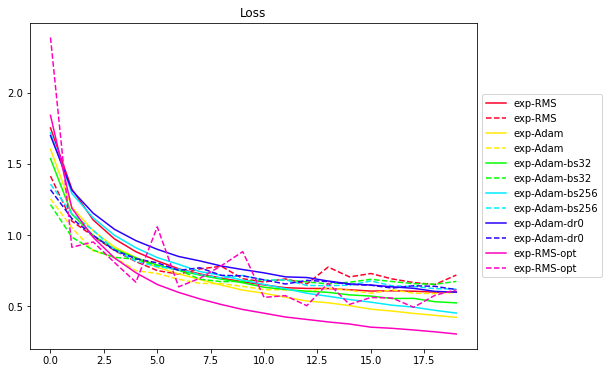

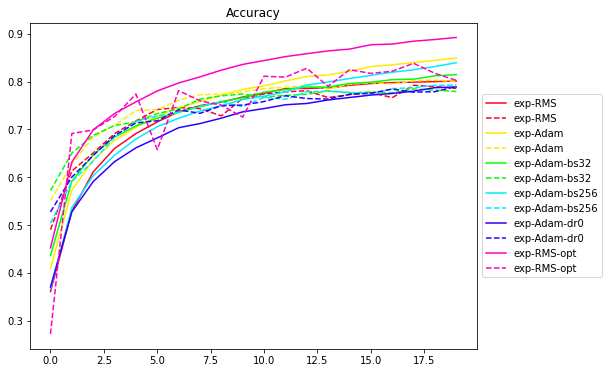

In [20]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()